In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=0)
output_dir = './output_lambda=0.3'
lambda_ = 0.3

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=0.3/train.log and ./output_lambda=0.3/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.83268, accuracy: 12.159 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  8516.96647, accuracy: 13.864 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.27177, accuracy: 13.395 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8463.32904, accuracy: 16.274 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.26065, accuracy: 15.137 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8407.05873, accuracy: 16.468 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.66830, accuracy: 15.925 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8362.04956, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.00375, accuracy: 16.342 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8302.44713, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.26379, accuracy: 16.604 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8249.58714, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.80263, accuracy: 16.769 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  8197.07034, accuracy: 17.438 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37868, accuracy: 16.924 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  8140.16752, accuracy: 17.742 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.54982, accuracy: 16.958 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8090.61440, accuracy: 17.735 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.85593, accuracy: 17.087 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8029.51185, accuracy: 17.722 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.57561, accuracy: 16.939 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7969.90773, accuracy: 18.116 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.78087, accuracy: 17.069 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7912.73863, accuracy: 17.791 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.74152, accuracy: 17.127 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7846.94010, accuracy: 17.902 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.65855, accuracy: 17.040 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7784.87645, accuracy: 17.853 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.35891, accuracy: 17.107 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7722.34267, accuracy: 18.234 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.64497, accuracy: 17.086 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  7658.14189, accuracy: 17.417 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.65895, accuracy: 16.973 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7589.41237, accuracy: 18.186 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.40073, accuracy: 16.999 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7521.62930, accuracy: 17.992 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.64223, accuracy: 16.856 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7453.31841, accuracy: 17.839 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.19673, accuracy: 16.912 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  7384.55909, accuracy: 18.082 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.85470, accuracy: 16.842 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7316.26983, accuracy: 18.525 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.08363, accuracy: 16.644 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  7242.41839, accuracy: 18.033 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.07502, accuracy: 16.533 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  7166.95254, accuracy: 17.313 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.77250, accuracy: 16.478 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  7094.36268, accuracy: 16.163 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.21114, accuracy: 16.437 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  7017.82114, accuracy: 17.188 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.61542, accuracy: 16.521 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6941.88570, accuracy: 17.867 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.14087, accuracy: 16.247 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6864.68617, accuracy: 17.583 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.16529, accuracy: 16.132 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6787.98892, accuracy: 17.729 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.87373, accuracy: 15.994 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  6711.22262, accuracy: 17.909 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.68035, accuracy: 15.930 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6630.79734, accuracy: 16.877 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.33078, accuracy: 15.821 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6551.21180, accuracy: 17.244 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.02204, accuracy: 15.792 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6471.07760, accuracy: 16.766 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.51314, accuracy: 15.672 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6390.63207, accuracy: 15.997 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.94735, accuracy: 15.370 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6312.29986, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.68274, accuracy: 15.099 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  6228.57068, accuracy: 16.496 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.68526, accuracy: 15.037 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  6146.23477, accuracy: 16.115 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.19091, accuracy: 14.895 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6063.15982, accuracy: 15.623 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.77975, accuracy: 14.718 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  5981.09126, accuracy: 15.706 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.98258, accuracy: 14.448 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5898.70362, accuracy: 15.769 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.49948, accuracy: 14.330 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5815.09548, accuracy: 13.712 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.35729, accuracy: 14.176 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5732.44134, accuracy: 14.204 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.20650, accuracy: 13.922 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5648.61599, accuracy: 13.802 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.30086, accuracy: 13.721 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5566.39888, accuracy: 13.089 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.13891, accuracy: 13.439 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5482.19794, accuracy: 13.303 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.82047, accuracy: 13.329 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5398.45427, accuracy: 12.798 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.03834, accuracy: 13.141 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5316.55070, accuracy: 12.597 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.50211, accuracy: 12.982 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5231.72438, accuracy: 12.126 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.95833, accuracy: 12.789 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5148.60384, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.03120, accuracy: 12.638 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5066.74496, accuracy: 12.084 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.76321, accuracy: 12.539 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4984.89691, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.71308, accuracy: 12.496 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4900.65233, accuracy: 12.050 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.50982, accuracy: 12.360 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  4818.22380, accuracy: 12.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.28886, accuracy: 12.312 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4736.60379, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.34106, accuracy: 12.252 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4656.28706, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.03924, accuracy: 12.160 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  4573.98648, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.27822, accuracy: 12.164 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4493.22202, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.84660, accuracy: 12.087 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4412.24932, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.42062, accuracy: 12.100 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4333.42742, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.95171, accuracy: 12.057 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4253.93945, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.06490, accuracy: 12.061 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4175.41476, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.03321, accuracy: 12.045 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  4096.24364, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.03100, accuracy: 12.033 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4019.35430, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.72983, accuracy: 12.027 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3942.81375, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.78169, accuracy: 12.022 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3865.87406, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.26141, accuracy: 12.023 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3790.16610, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.14706, accuracy: 12.019 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  3715.29247, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4133.00215, accuracy: 12.018 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3640.87545, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.21800, accuracy: 12.017 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3568.50307, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.45860, accuracy: 12.016 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3495.34843, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.90037, accuracy: 12.016 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3423.79628, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.98428, accuracy: 12.016 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  3352.55051, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.57352, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3282.26161, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.58037, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3212.93441, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.62142, accuracy: 12.016 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3144.19108, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.09602, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  3077.03343, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.41206, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3009.60410, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.23208, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2945.96418, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.29043, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2879.23318, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.80684, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  2814.82762, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.36647, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2752.13448, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.86183, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2690.46283, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.17719, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2628.49667, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.06706, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2568.57673, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.74641, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2508.27017, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.80803, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2450.28613, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.00029, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2393.04751, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.15711, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2336.73950, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.92813, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2280.93560, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.65028, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  2227.07699, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.51801, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2173.16757, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.58846, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2121.04961, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.99200, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2069.81647, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.10136, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2017.91375, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.17934, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1969.06954, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.05822, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1920.41719, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.59633, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1872.43403, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.46290, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1824.66229, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.72313, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1778.86422, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.17905, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1734.75478, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.47546, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1689.59411, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.49125, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1646.43241, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.25208, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1604.70362, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.37465, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  1563.82980, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.81721, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1523.23294, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.54551, accuracy: 12.015 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  1483.49451, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.64055, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1444.67477, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1807.02653, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1407.98982, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.91278, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1370.22407, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.86245, accuracy: 12.015 %, lr:  0.00001, elapse: 0.307 min


  - (Validation) ppl:  1334.72973, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.53157, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1299.12122, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.02329, accuracy: 12.015 %, lr:  0.00001, elapse: 0.306 min


  - (Validation) ppl:  1264.90436, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.42680, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1231.63437, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.43373, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  1199.35300, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.49600, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1167.27308, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.24671, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  1136.03586, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.54030, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  1105.96781, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.86892, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  1076.64928, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1401.04965, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  1047.76381, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.62809, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1019.78434, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1337.00716, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  992.74914, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.40187, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  966.05661, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.12750, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  939.96786, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.80796, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  915.36134, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.17139, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  890.50600, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.12962, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  866.55410, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.75380, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  843.16705, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.11053, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  820.74993, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.29670, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  798.92297, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.85037, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  777.57340, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.11201, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  756.85270, accuracy: 11.988 %, lr:  0.00002, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.01192, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  736.60485, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.61960, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  717.21953, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.71582, accuracy: 12.015 %, lr:  0.00002, elapse: 0.306 min


  - (Validation) ppl:  698.18778, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.45593, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  679.69009, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.80039, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  661.77485, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.65568, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  644.40834, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.17809, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  627.60656, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.25015, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  611.34438, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.81978, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  595.38890, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.93409, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  579.95666, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.62877, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  565.10020, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.78336, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  550.77522, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.49945, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  536.76457, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.74355, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  523.23077, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.38851, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  510.08678, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.50594, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  497.48031, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.12223, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  485.16729, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.23434, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  473.30394, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.75156, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  461.78351, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.64227, accuracy: 12.015 %, lr:  0.00002, elapse: 0.306 min


  - (Validation) ppl:  450.69990, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.03062, accuracy: 12.015 %, lr:  0.00002, elapse: 0.305 min


  - (Validation) ppl:  439.97751, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.81328, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  429.51069, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  644.97770, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  419.45407, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.59463, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  409.67602, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.56758, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  400.26904, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.92894, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  391.29002, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.62070, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  382.40947, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.71885, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  373.93627, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.13735, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  365.76369, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.95189, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  357.88841, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.12244, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  350.22750, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.62186, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  342.95742, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.39531, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  335.84653, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.57315, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  329.07406, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.02403, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  322.45029, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.79081, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  316.14057, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.88334, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  310.06100, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.28813, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  304.22267, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.01542, accuracy: 12.015 %, lr:  0.00002, elapse: 0.305 min


  - (Validation) ppl:  298.61809, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.05033, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  293.26872, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.39474, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  288.18196, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  468.99827, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  283.27813, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.85977, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  278.51839, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.94997, accuracy: 12.015 %, lr:  0.00002, elapse: 0.305 min


  - (Validation) ppl:  274.02484, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.24723, accuracy: 12.016 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  269.56828, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.84335, accuracy: 12.017 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  265.45715, accuracy: 12.001 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.36577, accuracy: 12.031 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  261.31567, accuracy: 12.001 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.20946, accuracy: 12.044 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  257.47572, accuracy: 12.078 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.13630, accuracy: 12.093 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  253.93258, accuracy: 12.119 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.23738, accuracy: 12.106 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  250.45594, accuracy: 12.078 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.43530, accuracy: 12.165 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  246.37123, accuracy: 12.188 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.83115, accuracy: 12.181 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  243.21810, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.33178, accuracy: 12.231 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  239.76308, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  406.94520, accuracy: 12.291 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  236.65713, accuracy: 12.168 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.64928, accuracy: 12.282 %, lr:  0.00002, elapse: 0.305 min


  - (Validation) ppl:  232.91834, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.45201, accuracy: 12.341 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  230.19424, accuracy: 12.112 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.16421, accuracy: 12.345 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  226.94497, accuracy: 12.057 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.21924, accuracy: 12.379 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  223.79962, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.26533, accuracy: 12.377 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  221.46931, accuracy: 12.008 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.31192, accuracy: 12.380 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  218.55665, accuracy: 12.029 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.45677, accuracy: 12.375 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  216.19588, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.63875, accuracy: 12.421 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  212.88248, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  370.89221, accuracy: 12.406 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  210.61861, accuracy: 12.036 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.16712, accuracy: 12.517 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  208.14782, accuracy: 12.278 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.46965, accuracy: 12.659 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  205.76045, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  359.86987, accuracy: 12.742 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  203.29660, accuracy: 12.244 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.42174, accuracy: 12.861 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  201.51301, accuracy: 13.179 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.44398, accuracy: 13.235 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  198.83737, accuracy: 13.712 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  348.92375, accuracy: 13.392 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  194.90011, accuracy: 13.012 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.13227, accuracy: 13.705 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  193.38187, accuracy: 13.518 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.40866, accuracy: 14.034 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  190.01146, accuracy: 13.414 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.67893, accuracy: 14.270 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  188.11686, accuracy: 14.335 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.06822, accuracy: 14.711 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  185.63937, accuracy: 15.048 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.19055, accuracy: 15.116 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  183.80851, accuracy: 14.404 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.23966, accuracy: 15.422 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  181.17669, accuracy: 14.356 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.51756, accuracy: 15.900 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  178.61643, accuracy: 15.810 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.85232, accuracy: 16.311 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  176.51691, accuracy: 15.727 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.08413, accuracy: 16.515 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  173.49280, accuracy: 15.485 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  310.95987, accuracy: 17.133 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  170.69648, accuracy: 17.320 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.26466, accuracy: 17.593 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  169.16499, accuracy: 17.812 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.32623, accuracy: 18.831 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  166.38801, accuracy: 17.604 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.64752, accuracy: 20.271 %, lr:  0.00003, elapse: 0.304 min


  - (Validation) ppl:  162.84752, accuracy: 17.431 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  295.91866, accuracy: 22.137 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  162.37868, accuracy: 21.046 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.43417, accuracy: 23.351 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  158.74381, accuracy: 24.709 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.64379, accuracy: 24.411 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  156.95140, accuracy: 24.668 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  284.89205, accuracy: 24.540 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  154.16379, accuracy: 24.751 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  280.86327, accuracy: 24.754 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  151.59849, accuracy: 24.605 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.38933, accuracy: 24.779 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  150.61834, accuracy: 24.903 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.40877, accuracy: 24.833 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  147.61624, accuracy: 24.875 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.15150, accuracy: 24.873 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  145.56247, accuracy: 24.986 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.39644, accuracy: 24.961 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  142.47595, accuracy: 24.889 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.81502, accuracy: 25.079 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  140.27625, accuracy: 25.159 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.13099, accuracy: 25.253 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  138.91040, accuracy: 25.374 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.43296, accuracy: 25.700 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  137.12194, accuracy: 26.371 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  251.98129, accuracy: 26.211 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  134.72984, accuracy: 27.902 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.58831, accuracy: 26.875 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  132.68501, accuracy: 28.193 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  244.86477, accuracy: 27.378 %, lr:  0.00003, elapse: 0.328 min


  - (Validation) ppl:  129.54316, accuracy: 28.137 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.80651, accuracy: 27.715 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  127.70294, accuracy: 28.047 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.15400, accuracy: 28.023 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  125.62987, accuracy: 28.414 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.69422, accuracy: 28.287 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  122.97920, accuracy: 28.470 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.45263, accuracy: 28.380 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  121.59904, accuracy: 28.518 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  227.90228, accuracy: 28.456 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  119.81872, accuracy: 28.504 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  224.62901, accuracy: 28.576 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  116.75883, accuracy: 28.622 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.55022, accuracy: 28.616 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  115.10567, accuracy: 28.705 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.33917, accuracy: 28.672 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  113.36791, accuracy: 28.650 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.49577, accuracy: 28.681 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  110.77698, accuracy: 28.753 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.45175, accuracy: 28.728 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  109.72899, accuracy: 28.774 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.21931, accuracy: 28.756 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  108.34203, accuracy: 28.747 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.38379, accuracy: 28.807 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  106.16876, accuracy: 28.871 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.26910, accuracy: 28.845 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  106.55131, accuracy: 28.747 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 264 ]


  - (Training)   ppl:  200.74758, accuracy: 28.855 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  103.26600, accuracy: 28.850 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  197.57257, accuracy: 28.926 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  100.75945, accuracy: 28.975 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.60479, accuracy: 28.886 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  99.74476, accuracy: 28.809 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.56894, accuracy: 28.956 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  98.53967, accuracy: 28.975 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  190.07708, accuracy: 28.983 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  96.92046, accuracy: 28.913 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  186.89068, accuracy: 29.061 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  95.63504, accuracy: 29.120 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.72860, accuracy: 29.052 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  93.58247, accuracy: 29.134 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.55456, accuracy: 29.078 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  92.57759, accuracy: 29.148 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.10951, accuracy: 29.102 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  90.80616, accuracy: 29.120 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.69152, accuracy: 29.132 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  89.34457, accuracy: 29.155 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.50281, accuracy: 29.192 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  88.28925, accuracy: 29.259 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.22103, accuracy: 29.192 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  87.98792, accuracy: 29.065 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  171.29810, accuracy: 29.217 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.78119, accuracy: 29.363 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  168.82411, accuracy: 29.274 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  84.83857, accuracy: 29.363 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  166.74660, accuracy: 29.303 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  83.36442, accuracy: 29.335 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  164.71079, accuracy: 29.382 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  82.49108, accuracy: 29.681 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.65668, accuracy: 29.471 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  80.87779, accuracy: 29.571 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.09193, accuracy: 29.555 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  80.63753, accuracy: 29.765 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  159.05828, accuracy: 29.617 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  78.63676, accuracy: 29.709 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.25736, accuracy: 29.712 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  77.61891, accuracy: 29.792 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.53856, accuracy: 29.793 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  77.11077, accuracy: 30.048 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.66016, accuracy: 29.904 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  76.54976, accuracy: 30.125 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.17253, accuracy: 29.955 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  74.94693, accuracy: 30.229 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.29118, accuracy: 30.022 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  74.38236, accuracy: 30.097 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.59160, accuracy: 30.150 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  73.39694, accuracy: 30.145 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.14191, accuracy: 30.223 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  72.31724, accuracy: 30.429 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.45983, accuracy: 30.301 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  71.33629, accuracy: 30.506 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  143.95690, accuracy: 30.411 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  70.81455, accuracy: 30.589 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  142.62614, accuracy: 30.466 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  70.32708, accuracy: 30.596 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.06641, accuracy: 30.597 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  68.49150, accuracy: 30.623 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.79759, accuracy: 30.642 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  67.96263, accuracy: 30.699 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.58450, accuracy: 30.745 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  68.10949, accuracy: 30.609 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 296 ]


  - (Training)   ppl:  136.90477, accuracy: 30.902 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  66.38182, accuracy: 30.997 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  135.89885, accuracy: 30.941 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  65.66353, accuracy: 30.914 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.31699, accuracy: 31.119 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  65.17358, accuracy: 31.454 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.19737, accuracy: 31.162 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  64.75855, accuracy: 31.060 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  131.92728, accuracy: 31.289 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  63.80640, accuracy: 31.219 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  130.88244, accuracy: 31.370 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  63.26410, accuracy: 31.724 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.64126, accuracy: 31.491 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  62.15165, accuracy: 31.704 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  128.62309, accuracy: 31.629 %, lr:  0.00003, elapse: 0.305 min


  - (Validation) ppl:  61.98325, accuracy: 31.724 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.24389, accuracy: 31.721 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  61.44640, accuracy: 31.898 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.29071, accuracy: 31.829 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  60.80720, accuracy: 32.188 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.06677, accuracy: 31.946 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  59.94860, accuracy: 32.168 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.38042, accuracy: 32.028 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  59.48461, accuracy: 32.438 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.06951, accuracy: 32.101 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  59.13220, accuracy: 32.507 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  122.09343, accuracy: 32.280 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  58.66065, accuracy: 32.410 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  121.03503, accuracy: 32.353 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  58.08257, accuracy: 32.597 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.02743, accuracy: 32.447 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  57.49844, accuracy: 32.687 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  119.18909, accuracy: 32.520 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  56.86168, accuracy: 32.715 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.21537, accuracy: 32.602 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  56.09088, accuracy: 32.971 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.36698, accuracy: 32.694 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  56.29327, accuracy: 32.805 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.65111, accuracy: 32.720 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  55.40288, accuracy: 32.922 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.62055, accuracy: 32.788 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  55.12227, accuracy: 32.999 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  114.62653, accuracy: 32.927 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  54.16439, accuracy: 33.096 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.08508, accuracy: 32.901 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  53.76895, accuracy: 33.116 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  113.19504, accuracy: 32.982 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  53.43377, accuracy: 33.144 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.39210, accuracy: 33.109 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  53.18738, accuracy: 33.303 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 321 ]


  - (Training)   ppl:  111.52738, accuracy: 33.211 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  52.72506, accuracy: 33.587 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  110.97598, accuracy: 33.218 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  52.12270, accuracy: 33.864 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  109.86809, accuracy: 33.419 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  51.76140, accuracy: 33.726 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  109.10279, accuracy: 33.513 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  51.58732, accuracy: 33.850 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.44686, accuracy: 33.584 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  51.21976, accuracy: 33.989 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.82255, accuracy: 33.691 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  50.34992, accuracy: 33.906 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  106.98887, accuracy: 33.828 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  50.02656, accuracy: 34.127 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.41136, accuracy: 33.853 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  50.25256, accuracy: 34.273 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  105.60284, accuracy: 33.952 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  49.82755, accuracy: 34.231 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.08844, accuracy: 34.008 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  49.15730, accuracy: 34.550 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.26663, accuracy: 34.082 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  48.99633, accuracy: 34.661 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  103.57689, accuracy: 34.200 %, lr:  0.00004, elapse: 0.305 min


  - (Validation) ppl:  48.24012, accuracy: 34.778 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.79962, accuracy: 34.253 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  48.45293, accuracy: 34.758 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 334 ]


  - (Training)   ppl:  102.25062, accuracy: 34.325 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  48.18298, accuracy: 34.855 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  101.47649, accuracy: 34.439 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  47.47898, accuracy: 34.882 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  101.10468, accuracy: 34.440 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  47.23979, accuracy: 35.048 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.36997, accuracy: 34.571 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.60360, accuracy: 35.159 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.88533, accuracy: 34.569 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  46.68368, accuracy: 35.215 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 339 ]


  - (Training)   ppl:  99.05359, accuracy: 34.697 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  45.85094, accuracy: 35.173 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.72512, accuracy: 34.696 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  46.01881, accuracy: 35.291 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  98.17134, accuracy: 34.772 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  46.33538, accuracy: 34.889 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 342 ]


  - (Training)   ppl:  97.24697, accuracy: 34.986 %, lr:  0.00004, elapse: 0.305 min


  - (Validation) ppl:  45.09970, accuracy: 35.506 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 343 ]


  - (Training)   ppl:  96.67665, accuracy: 35.105 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  44.64227, accuracy: 35.596 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  95.81439, accuracy: 35.211 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  45.36964, accuracy: 35.215 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 345 ]


  - (Training)   ppl:  95.74352, accuracy: 35.182 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  44.23963, accuracy: 35.741 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  94.91752, accuracy: 35.297 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  43.93153, accuracy: 35.983 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  94.24718, accuracy: 35.428 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  43.50682, accuracy: 36.018 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  93.89050, accuracy: 35.460 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  43.30006, accuracy: 36.150 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  93.32249, accuracy: 35.588 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  42.86361, accuracy: 36.039 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.70160, accuracy: 35.645 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  43.23368, accuracy: 36.046 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 351 ]


  - (Training)   ppl:  92.18583, accuracy: 35.699 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  42.35754, accuracy: 36.357 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.70125, accuracy: 35.756 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  42.19328, accuracy: 36.267 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  90.95993, accuracy: 35.849 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  42.08443, accuracy: 36.136 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  90.47261, accuracy: 35.903 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  42.08011, accuracy: 36.253 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  89.91374, accuracy: 35.992 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  41.45422, accuracy: 36.434 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  89.16804, accuracy: 36.026 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  40.70379, accuracy: 36.558 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  88.71661, accuracy: 36.101 %, lr:  0.00004, elapse: 0.306 min


  - (Validation) ppl:  40.37045, accuracy: 36.579 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  88.09476, accuracy: 36.119 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  40.30567, accuracy: 36.572 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 359 ]


  - (Training)   ppl:  87.84727, accuracy: 36.078 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  40.16208, accuracy: 36.551 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  87.13967, accuracy: 36.206 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  39.60992, accuracy: 36.510 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  86.58970, accuracy: 36.267 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  39.14447, accuracy: 36.669 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  86.05504, accuracy: 36.278 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  38.99169, accuracy: 36.752 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  85.32731, accuracy: 36.398 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  38.87015, accuracy: 36.953 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  84.80458, accuracy: 36.484 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  38.60137, accuracy: 37.244 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  84.47046, accuracy: 36.509 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  38.02412, accuracy: 37.639 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  83.66885, accuracy: 36.691 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  37.68817, accuracy: 37.562 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  82.95347, accuracy: 36.886 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  37.55473, accuracy: 37.666 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  82.82280, accuracy: 37.034 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  37.51278, accuracy: 37.403 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  82.46549, accuracy: 37.050 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  36.97280, accuracy: 37.832 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  81.86157, accuracy: 37.160 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  36.75652, accuracy: 37.687 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  81.27368, accuracy: 37.293 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  36.55859, accuracy: 37.798 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  80.79353, accuracy: 37.414 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  36.75766, accuracy: 37.825 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  80.28919, accuracy: 37.524 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  36.13418, accuracy: 37.902 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  79.59350, accuracy: 37.631 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  35.98016, accuracy: 38.116 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  79.32717, accuracy: 37.695 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  36.44281, accuracy: 37.528 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 376 ]


  - (Training)   ppl:  79.13031, accuracy: 37.731 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.86408, accuracy: 38.400 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  78.32427, accuracy: 37.929 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  35.46862, accuracy: 38.186 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  77.90134, accuracy: 37.985 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  35.27138, accuracy: 38.331 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  77.65018, accuracy: 38.000 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  34.89529, accuracy: 38.428 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  77.37497, accuracy: 38.073 %, lr:  0.00004, elapse: 0.306 min


  - (Validation) ppl:  34.83130, accuracy: 38.629 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  76.45839, accuracy: 38.282 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  34.80168, accuracy: 38.532 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  76.12045, accuracy: 38.313 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.50964, accuracy: 38.934 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  75.98442, accuracy: 38.328 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.42922, accuracy: 38.871 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  75.42978, accuracy: 38.514 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  33.84479, accuracy: 39.100 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  74.76076, accuracy: 38.640 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.66390, accuracy: 39.273 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  74.51823, accuracy: 38.674 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  33.54205, accuracy: 39.321 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  74.16317, accuracy: 38.745 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.17824, accuracy: 39.238 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 388 ]


  - (Training)   ppl:  73.93068, accuracy: 38.725 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  33.55641, accuracy: 39.231 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  73.35704, accuracy: 38.932 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  32.81214, accuracy: 39.668 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  72.90052, accuracy: 39.033 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  32.74021, accuracy: 39.765 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  72.61285, accuracy: 39.089 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  32.43985, accuracy: 39.778 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 392 ]


  - (Training)   ppl:  71.83535, accuracy: 39.243 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  32.32494, accuracy: 39.744 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 393 ]


  - (Training)   ppl:  71.65628, accuracy: 39.274 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  32.26749, accuracy: 39.827 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  71.50147, accuracy: 39.314 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  31.91331, accuracy: 40.021 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  70.89183, accuracy: 39.458 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  32.02995, accuracy: 39.896 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 396 ]


  - (Training)   ppl:  70.67436, accuracy: 39.490 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  31.58704, accuracy: 40.229 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  70.22756, accuracy: 39.598 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  31.36002, accuracy: 40.305 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 398 ]


  - (Training)   ppl:  69.80356, accuracy: 39.663 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  31.20545, accuracy: 40.104 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 399 ]


  - (Training)   ppl:  69.46170, accuracy: 39.701 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  31.37243, accuracy: 40.319 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 400 ]


  - (Training)   ppl:  69.12892, accuracy: 39.811 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  31.42870, accuracy: 39.910 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  68.78619, accuracy: 39.890 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  30.84580, accuracy: 40.512 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  68.52303, accuracy: 39.919 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  30.26478, accuracy: 40.512 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  67.89473, accuracy: 40.080 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  30.22028, accuracy: 40.734 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  67.52034, accuracy: 40.222 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  30.07978, accuracy: 40.554 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  67.22911, accuracy: 40.234 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.56584, accuracy: 40.644 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  66.97719, accuracy: 40.257 %, lr:  0.00004, elapse: 0.306 min


  - (Validation) ppl:  29.71137, accuracy: 40.831 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  66.63744, accuracy: 40.336 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  29.41072, accuracy: 40.900 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  66.02457, accuracy: 40.556 %, lr:  0.00004, elapse: 0.304 min


  - (Validation) ppl:  29.48181, accuracy: 40.900 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 409 ]


  - (Training)   ppl:  65.87336, accuracy: 40.514 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  29.30554, accuracy: 41.150 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  65.49534, accuracy: 40.670 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  29.47137, accuracy: 40.845 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 411 ]


  - (Training)   ppl:  65.24933, accuracy: 40.734 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  28.70210, accuracy: 41.288 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  64.85843, accuracy: 40.748 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  29.12340, accuracy: 41.191 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 413 ]


  - (Training)   ppl:  64.35535, accuracy: 40.962 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.91720, accuracy: 41.122 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 414 ]


  - (Training)   ppl:  64.15249, accuracy: 40.981 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  28.90058, accuracy: 41.094 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 415 ]


  - (Training)   ppl:  63.55199, accuracy: 41.194 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  28.22747, accuracy: 41.309 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  63.42173, accuracy: 41.122 %, lr:  0.00005, elapse: 0.305 min


  - (Validation) ppl:  28.78804, accuracy: 41.350 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  63.27437, accuracy: 41.178 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  28.22862, accuracy: 41.510 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 418 ]


  - (Training)   ppl:  62.97638, accuracy: 41.290 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.01830, accuracy: 41.482 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  62.39901, accuracy: 41.421 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  27.82140, accuracy: 41.752 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  62.21409, accuracy: 41.512 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  27.44676, accuracy: 41.953 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  61.60816, accuracy: 41.712 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.60606, accuracy: 41.988 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  61.65492, accuracy: 41.633 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  27.28853, accuracy: 41.870 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  61.17307, accuracy: 41.807 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  27.49644, accuracy: 42.057 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 424 ]


  - (Training)   ppl:  60.97367, accuracy: 41.821 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  27.03262, accuracy: 42.278 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  60.52673, accuracy: 41.953 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  26.58134, accuracy: 42.271 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  60.20745, accuracy: 42.033 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  26.84009, accuracy: 42.244 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  59.67266, accuracy: 42.217 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  26.44112, accuracy: 42.645 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  59.71585, accuracy: 42.129 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  26.38767, accuracy: 42.368 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  59.47393, accuracy: 42.244 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  26.19852, accuracy: 42.507 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 430 ]


  - (Training)   ppl:  58.87025, accuracy: 42.386 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  26.10716, accuracy: 42.604 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  58.59714, accuracy: 42.491 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.96036, accuracy: 42.639 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  58.28099, accuracy: 42.627 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  25.75467, accuracy: 42.618 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  57.93897, accuracy: 42.662 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  26.30119, accuracy: 42.375 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  57.94637, accuracy: 42.665 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.75278, accuracy: 42.867 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 435 ]


  - (Training)   ppl:  57.65055, accuracy: 42.778 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  26.09942, accuracy: 42.507 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 436 ]


  - (Training)   ppl:  57.15741, accuracy: 42.868 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  25.54802, accuracy: 42.929 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  56.67664, accuracy: 43.066 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.41002, accuracy: 42.943 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  56.75405, accuracy: 42.999 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  24.99264, accuracy: 43.151 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  56.49725, accuracy: 43.079 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.89837, accuracy: 43.068 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 440 ]


  - (Training)   ppl:  56.06574, accuracy: 43.235 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  24.83030, accuracy: 43.241 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  55.69644, accuracy: 43.396 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  24.75948, accuracy: 43.303 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 442 ]


  - (Training)   ppl:  55.61781, accuracy: 43.399 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.81211, accuracy: 43.206 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 443 ]


  - (Training)   ppl:  54.93478, accuracy: 43.645 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  24.19222, accuracy: 43.795 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  54.73766, accuracy: 43.700 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.17917, accuracy: 44.162 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  54.62026, accuracy: 43.769 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.60743, accuracy: 43.442 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  54.17893, accuracy: 43.907 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.17110, accuracy: 43.954 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 447 ]


  - (Training)   ppl:  54.05278, accuracy: 43.923 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.81208, accuracy: 43.989 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  53.58147, accuracy: 44.138 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  23.74681, accuracy: 44.211 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  53.30149, accuracy: 44.203 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  23.43250, accuracy: 44.716 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  52.87816, accuracy: 44.364 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  23.64419, accuracy: 44.127 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 451 ]


  - (Training)   ppl:  52.74312, accuracy: 44.392 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  23.80073, accuracy: 44.245 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  52.51031, accuracy: 44.482 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  23.49899, accuracy: 44.675 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  52.27014, accuracy: 44.568 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  23.05453, accuracy: 44.799 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  51.76404, accuracy: 44.719 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.78829, accuracy: 45.104 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  51.37172, accuracy: 44.911 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  22.96571, accuracy: 44.841 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  51.02768, accuracy: 45.016 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  22.49845, accuracy: 45.187 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  50.86398, accuracy: 44.997 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  22.44499, accuracy: 45.312 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  50.59706, accuracy: 45.204 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  22.69311, accuracy: 45.035 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  50.23612, accuracy: 45.321 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.22811, accuracy: 45.741 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  49.75242, accuracy: 45.492 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.22652, accuracy: 45.519 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 461 ]


  - (Training)   ppl:  49.76814, accuracy: 45.447 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  21.96979, accuracy: 45.699 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  49.48187, accuracy: 45.500 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  22.25697, accuracy: 45.568 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 463 ]


  - (Training)   ppl:  49.17903, accuracy: 45.659 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.74848, accuracy: 45.852 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 464 ]


  - (Training)   ppl:  48.70537, accuracy: 45.903 %, lr:  0.00005, elapse: 0.306 min


  - (Validation) ppl:  21.43929, accuracy: 46.004 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  48.60700, accuracy: 45.860 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  21.67718, accuracy: 45.921 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 466 ]


  - (Training)   ppl:  48.19169, accuracy: 46.081 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  21.26811, accuracy: 46.170 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  47.91500, accuracy: 46.155 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  20.94421, accuracy: 46.600 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  47.58257, accuracy: 46.234 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  20.98404, accuracy: 46.434 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  47.44127, accuracy: 46.292 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.96707, accuracy: 46.350 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  47.30703, accuracy: 46.274 %, lr:  0.00005, elapse: 0.305 min


  - (Validation) ppl:  21.33820, accuracy: 46.191 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 471 ]


  - (Training)   ppl:  46.60476, accuracy: 46.644 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.60768, accuracy: 46.586 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  46.31336, accuracy: 46.761 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.37998, accuracy: 46.780 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  46.01511, accuracy: 46.826 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  20.62408, accuracy: 46.690 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  45.82059, accuracy: 46.941 %, lr:  0.00005, elapse: 0.306 min


  - (Validation) ppl:  20.13487, accuracy: 47.175 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  45.96104, accuracy: 46.899 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  20.28665, accuracy: 47.161 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  45.43426, accuracy: 47.057 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  20.23973, accuracy: 47.008 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  44.72953, accuracy: 47.484 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  19.97205, accuracy: 47.265 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  44.86147, accuracy: 47.357 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  19.80521, accuracy: 47.361 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  44.41981, accuracy: 47.531 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.33635, accuracy: 47.708 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  44.23523, accuracy: 47.545 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  19.53649, accuracy: 47.590 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 481 ]


  - (Training)   ppl:  43.87206, accuracy: 47.778 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  19.25938, accuracy: 47.909 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 482 ]


  - (Training)   ppl:  43.55830, accuracy: 47.889 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  19.23225, accuracy: 48.047 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  43.15974, accuracy: 48.106 %, lr:  0.00005, elapse: 0.305 min


  - (Validation) ppl:  19.17679, accuracy: 48.262 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  42.89512, accuracy: 48.210 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  18.87216, accuracy: 48.373 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  42.58109, accuracy: 48.357 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  19.01040, accuracy: 48.054 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 486 ]


  - (Training)   ppl:  42.28619, accuracy: 48.436 %, lr:  0.00005, elapse: 0.305 min


  - (Validation) ppl:  18.48887, accuracy: 48.795 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  41.81286, accuracy: 48.702 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.33370, accuracy: 48.726 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  41.61500, accuracy: 48.693 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  18.39141, accuracy: 48.663 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 489 ]


  - (Training)   ppl:  41.29875, accuracy: 48.921 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.13265, accuracy: 48.968 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  41.09335, accuracy: 48.962 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.25331, accuracy: 48.670 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 491 ]


  - (Training)   ppl:  40.84709, accuracy: 49.088 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  17.83933, accuracy: 49.259 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  40.39063, accuracy: 49.362 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.74118, accuracy: 49.294 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 493 ]


  - (Training)   ppl:  40.17006, accuracy: 49.388 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  17.76560, accuracy: 49.037 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 494 ]


  - (Training)   ppl:  39.82879, accuracy: 49.557 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  17.42191, accuracy: 49.640 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  39.54762, accuracy: 49.743 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  17.25943, accuracy: 49.861 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 496 ]


  - (Training)   ppl:  39.10907, accuracy: 49.965 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  17.01224, accuracy: 49.896 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  38.86934, accuracy: 50.054 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  17.17920, accuracy: 49.834 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 498 ]


  - (Training)   ppl:  38.75583, accuracy: 50.070 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  17.07398, accuracy: 50.104 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 499 ]


  - (Training)   ppl:  38.00356, accuracy: 50.549 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  16.88244, accuracy: 50.346 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  38.04398, accuracy: 50.521 %, lr:  0.00006, elapse: 0.328 min


  - (Validation) ppl:  16.88946, accuracy: 49.958 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 501 ]


  - (Training)   ppl:  37.51477, accuracy: 50.818 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  16.43631, accuracy: 51.004 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  37.18388, accuracy: 51.032 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  16.34899, accuracy: 50.679 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  36.97507, accuracy: 51.092 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.97004, accuracy: 51.406 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  36.45934, accuracy: 51.363 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  15.65307, accuracy: 51.551 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 505 ]


  - (Training)   ppl:  36.18886, accuracy: 51.602 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  16.11483, accuracy: 51.226 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  35.86661, accuracy: 51.764 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  15.38179, accuracy: 52.091 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  35.61882, accuracy: 51.913 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.46999, accuracy: 51.918 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 508 ]


  - (Training)   ppl:  35.26830, accuracy: 52.108 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  15.57867, accuracy: 52.064 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 509 ]


  - (Training)   ppl:  34.90336, accuracy: 52.360 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  15.07502, accuracy: 52.548 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  34.74014, accuracy: 52.448 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  14.99551, accuracy: 52.555 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 511 ]


  - (Training)   ppl:  34.33355, accuracy: 52.694 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.93396, accuracy: 52.569 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  34.06714, accuracy: 52.830 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.77734, accuracy: 52.985 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  33.74488, accuracy: 53.042 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  14.61183, accuracy: 53.061 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  33.41111, accuracy: 53.276 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.43258, accuracy: 53.400 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  32.96604, accuracy: 53.571 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  14.49209, accuracy: 53.130 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 516 ]


  - (Training)   ppl:  32.86749, accuracy: 53.644 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  14.10155, accuracy: 53.587 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  32.61811, accuracy: 53.828 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.31034, accuracy: 53.137 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 518 ]


  - (Training)   ppl:  32.46180, accuracy: 53.846 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.86554, accuracy: 54.287 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  32.07555, accuracy: 54.135 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  13.87890, accuracy: 54.148 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 520 ]


  - (Training)   ppl:  31.56699, accuracy: 54.442 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  13.49896, accuracy: 54.695 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  31.30236, accuracy: 54.605 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  13.40599, accuracy: 54.834 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  31.05073, accuracy: 54.791 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  13.42369, accuracy: 54.695 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  30.75070, accuracy: 54.968 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  13.21196, accuracy: 54.737 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  30.42014, accuracy: 55.192 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  13.20011, accuracy: 54.965 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 525 ]


  - (Training)   ppl:  30.04586, accuracy: 55.478 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  13.27047, accuracy: 54.605 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  30.02182, accuracy: 55.536 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  13.04388, accuracy: 55.284 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 527 ]


  - (Training)   ppl:  29.67185, accuracy: 55.739 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  12.83290, accuracy: 55.429 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  29.32135, accuracy: 55.988 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.00059, accuracy: 55.014 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  29.10611, accuracy: 56.153 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  12.52683, accuracy: 55.575 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  28.77480, accuracy: 56.301 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  12.36244, accuracy: 55.907 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  28.66909, accuracy: 56.391 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.40815, accuracy: 56.136 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  28.34528, accuracy: 56.629 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  12.30534, accuracy: 56.108 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  28.05957, accuracy: 56.823 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.13181, accuracy: 56.530 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  27.81628, accuracy: 56.968 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.11014, accuracy: 56.524 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 535 ]


  - (Training)   ppl:  27.48261, accuracy: 57.231 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.23272, accuracy: 55.983 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 536 ]


  - (Training)   ppl:  27.17663, accuracy: 57.443 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.89975, accuracy: 56.925 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  26.99933, accuracy: 57.575 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.70264, accuracy: 57.271 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  26.82788, accuracy: 57.695 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.66301, accuracy: 57.271 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  26.76102, accuracy: 57.762 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.67994, accuracy: 57.050 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 540 ]


  - (Training)   ppl:  26.31698, accuracy: 58.111 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  11.46484, accuracy: 57.299 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  26.12064, accuracy: 58.235 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.38148, accuracy: 57.458 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 542 ]


  - (Training)   ppl:  25.91483, accuracy: 58.368 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  11.41162, accuracy: 57.361 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 543 ]


  - (Training)   ppl:  25.67574, accuracy: 58.591 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.36830, accuracy: 57.202 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 544 ]


  - (Training)   ppl:  25.45908, accuracy: 58.746 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  11.25031, accuracy: 57.777 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 545 ]


  - (Training)   ppl:  25.21582, accuracy: 58.918 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  11.22825, accuracy: 57.922 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 546 ]


  - (Training)   ppl:  24.97303, accuracy: 59.186 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  10.96242, accuracy: 58.137 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  24.75125, accuracy: 59.293 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  11.10488, accuracy: 57.805 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  24.57841, accuracy: 59.386 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.90826, accuracy: 58.289 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  24.29802, accuracy: 59.625 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.76884, accuracy: 58.276 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 550 ]


  - (Training)   ppl:  24.11639, accuracy: 59.757 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  10.72557, accuracy: 58.511 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  23.87458, accuracy: 59.996 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  10.53345, accuracy: 58.809 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  23.71197, accuracy: 60.141 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  10.76982, accuracy: 58.324 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  23.52365, accuracy: 60.253 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.50849, accuracy: 58.795 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  23.29647, accuracy: 60.398 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  10.50760, accuracy: 59.010 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 555 ]


  - (Training)   ppl:  23.08458, accuracy: 60.625 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  10.23678, accuracy: 59.211 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  22.93018, accuracy: 60.779 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  10.32228, accuracy: 59.543 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  22.65339, accuracy: 60.962 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  10.20819, accuracy: 59.425 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  22.62328, accuracy: 60.970 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  10.21673, accuracy: 59.584 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  22.36863, accuracy: 61.251 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.01398, accuracy: 59.744 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  22.25552, accuracy: 61.345 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.93159, accuracy: 59.868 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  22.04508, accuracy: 61.461 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.92131, accuracy: 59.931 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 562 ]


  - (Training)   ppl:  21.79934, accuracy: 61.706 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.88604, accuracy: 60.035 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 563 ]


  - (Training)   ppl:  21.70196, accuracy: 61.869 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.77447, accuracy: 60.125 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  21.48894, accuracy: 62.034 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.85188, accuracy: 60.298 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  21.30962, accuracy: 62.107 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.70258, accuracy: 60.229 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  21.05043, accuracy: 62.381 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  9.69379, accuracy: 60.367 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 567 ]


  - (Training)   ppl:  20.94703, accuracy: 62.485 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.63225, accuracy: 60.512 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  20.83120, accuracy: 62.604 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.57199, accuracy: 60.748 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 569 ]


  - (Training)   ppl:  20.63827, accuracy: 62.775 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.55455, accuracy: 60.713 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  20.48319, accuracy: 62.879 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.58218, accuracy: 60.762 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 571 ]


  - (Training)   ppl:  20.24901, accuracy: 63.101 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.36795, accuracy: 60.990 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  20.10451, accuracy: 63.231 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.40796, accuracy: 60.893 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 573 ]


  - (Training)   ppl:  19.89977, accuracy: 63.486 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.19731, accuracy: 60.990 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  19.73495, accuracy: 63.562 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.38620, accuracy: 60.727 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 575 ]


  - (Training)   ppl:  19.72646, accuracy: 63.504 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  9.31614, accuracy: 61.198 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 576 ]


  - (Training)   ppl:  19.43931, accuracy: 63.896 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.09179, accuracy: 61.440 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  19.29594, accuracy: 64.020 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.21777, accuracy: 61.198 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 578 ]


  - (Training)   ppl:  19.22784, accuracy: 64.080 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.16598, accuracy: 61.157 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 579 ]


  - (Training)   ppl:  19.02200, accuracy: 64.235 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.17652, accuracy: 61.094 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  18.93724, accuracy: 64.382 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.10699, accuracy: 61.385 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  18.70463, accuracy: 64.558 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  8.96934, accuracy: 61.627 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  18.63142, accuracy: 64.664 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.83502, accuracy: 61.877 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 583 ]


  - (Training)   ppl:  18.38937, accuracy: 64.899 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.03800, accuracy: 61.662 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  18.34254, accuracy: 64.890 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.06311, accuracy: 61.350 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  18.22765, accuracy: 65.001 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  8.79048, accuracy: 61.842 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  18.06977, accuracy: 65.212 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  8.79648, accuracy: 61.891 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  17.96819, accuracy: 65.348 %, lr:  0.00006, elapse: 0.306 min


  - (Validation) ppl:  8.76009, accuracy: 61.717 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  17.79382, accuracy: 65.475 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.72343, accuracy: 62.008 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 589 ]


  - (Training)   ppl:  17.66235, accuracy: 65.637 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.72652, accuracy: 61.932 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  17.55993, accuracy: 65.731 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.63471, accuracy: 62.112 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 591 ]


  - (Training)   ppl:  17.49935, accuracy: 65.790 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.57147, accuracy: 62.161 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.34759, accuracy: 65.955 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.57096, accuracy: 62.064 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 593 ]


  - (Training)   ppl:  17.12862, accuracy: 66.251 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.60420, accuracy: 62.161 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  17.05320, accuracy: 66.314 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.44899, accuracy: 62.361 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.06318, accuracy: 66.265 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.65530, accuracy: 62.036 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  16.83840, accuracy: 66.545 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.34766, accuracy: 62.583 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 597 ]


  - (Training)   ppl:  16.67213, accuracy: 66.709 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.49962, accuracy: 62.562 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  16.59240, accuracy: 66.818 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.38297, accuracy: 62.500 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  16.60825, accuracy: 66.718 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.35659, accuracy: 62.597 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  16.46473, accuracy: 66.902 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.24374, accuracy: 62.798 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.23222, accuracy: 67.209 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.25292, accuracy: 62.673 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  16.11840, accuracy: 67.348 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  8.20665, accuracy: 62.639 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  16.03973, accuracy: 67.444 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.25814, accuracy: 62.916 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 604 ]


  - (Training)   ppl:  15.93201, accuracy: 67.572 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.14592, accuracy: 63.061 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  15.84966, accuracy: 67.625 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.14433, accuracy: 62.805 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 606 ]


  - (Training)   ppl:  15.66214, accuracy: 67.948 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  8.21002, accuracy: 62.950 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  15.71217, accuracy: 67.848 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  8.14624, accuracy: 63.006 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 608 ]


  - (Training)   ppl:  15.44487, accuracy: 68.205 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.36489, accuracy: 62.597 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  15.44154, accuracy: 68.170 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.06518, accuracy: 63.186 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.28468, accuracy: 68.423 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.11808, accuracy: 62.909 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  15.12470, accuracy: 68.580 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.10708, accuracy: 62.964 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.01693, accuracy: 68.693 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  8.03789, accuracy: 63.019 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 613 ]


  - (Training)   ppl:  14.98921, accuracy: 68.772 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  8.15671, accuracy: 63.172 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  14.82655, accuracy: 68.907 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.98390, accuracy: 63.276 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 615 ]


  - (Training)   ppl:  14.78362, accuracy: 68.975 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.00975, accuracy: 63.338 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  14.69852, accuracy: 69.083 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.93222, accuracy: 63.449 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 617 ]


  - (Training)   ppl:  14.61414, accuracy: 69.201 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.92800, accuracy: 63.573 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 618 ]


  - (Training)   ppl:  14.51652, accuracy: 69.332 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.87846, accuracy: 63.560 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 619 ]


  - (Training)   ppl:  14.39440, accuracy: 69.482 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.85782, accuracy: 63.684 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 620 ]


  - (Training)   ppl:  14.26092, accuracy: 69.660 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.82177, accuracy: 63.878 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.26126, accuracy: 69.692 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.89159, accuracy: 63.719 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.15004, accuracy: 69.846 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.96911, accuracy: 63.442 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.06678, accuracy: 69.915 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.84759, accuracy: 63.691 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  13.99819, accuracy: 69.971 %, lr:  0.00007, elapse: 0.306 min


  - (Validation) ppl:  7.74030, accuracy: 64.072 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 625 ]


  - (Training)   ppl:  13.89187, accuracy: 70.139 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.73479, accuracy: 63.837 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 626 ]


  - (Training)   ppl:  13.68503, accuracy: 70.509 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.77891, accuracy: 63.857 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  13.63830, accuracy: 70.522 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.77178, accuracy: 63.961 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  13.52876, accuracy: 70.741 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.88399, accuracy: 63.913 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.58015, accuracy: 70.628 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.83292, accuracy: 63.857 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  13.38061, accuracy: 70.895 %, lr:  0.00007, elapse: 0.305 min


  - (Validation) ppl:  7.69412, accuracy: 64.217 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 631 ]


  - (Training)   ppl:  13.36434, accuracy: 70.960 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.66050, accuracy: 64.162 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  13.38614, accuracy: 70.861 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.87906, accuracy: 63.996 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.16184, accuracy: 71.212 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.81127, accuracy: 63.871 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.13756, accuracy: 71.261 %, lr:  0.00007, elapse: 0.305 min


  - (Validation) ppl:  7.73845, accuracy: 64.391 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.00013, accuracy: 71.473 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.65601, accuracy: 64.515 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 636 ]


  - (Training)   ppl:  12.98221, accuracy: 71.438 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.64768, accuracy: 64.550 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 637 ]


  - (Training)   ppl:  12.87085, accuracy: 71.695 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.45882, accuracy: 64.668 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  12.90363, accuracy: 71.586 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.64678, accuracy: 64.758 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  12.70272, accuracy: 71.953 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.49981, accuracy: 64.681 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  12.58896, accuracy: 72.163 %, lr:  0.00007, elapse: 0.328 min


  - (Validation) ppl:  7.57533, accuracy: 64.958 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.57015, accuracy: 72.155 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.53679, accuracy: 64.612 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  12.45206, accuracy: 72.307 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.56919, accuracy: 64.675 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 643 ]


  - (Training)   ppl:  12.36973, accuracy: 72.488 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.55593, accuracy: 64.945 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  12.29678, accuracy: 72.557 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.48145, accuracy: 64.979 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  12.26811, accuracy: 72.682 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.50117, accuracy: 64.965 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 646 ]


  - (Training)   ppl:  12.17812, accuracy: 72.720 %, lr:  0.00007, elapse: 0.304 min


  - (Validation) ppl:  7.55877, accuracy: 64.979 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  12.10747, accuracy: 72.841 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.52992, accuracy: 64.751 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.05388, accuracy: 73.007 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.55316, accuracy: 64.882 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  11.91846, accuracy: 73.241 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.35852, accuracy: 65.346 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 650 ]


  - (Training)   ppl:  11.93996, accuracy: 73.152 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.48199, accuracy: 64.965 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  11.83971, accuracy: 73.327 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.44233, accuracy: 65.325 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  11.73463, accuracy: 73.538 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.45599, accuracy: 64.958 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  11.69976, accuracy: 73.560 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.45735, accuracy: 65.429 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.69831, accuracy: 73.517 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.44545, accuracy: 65.360 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  11.61450, accuracy: 73.691 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  7.34572, accuracy: 65.540 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 656 ]


  - (Training)   ppl:  11.48233, accuracy: 73.955 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.40569, accuracy: 65.499 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 657 ]


  - (Training)   ppl:  11.38496, accuracy: 74.126 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  7.41222, accuracy: 65.339 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  11.43353, accuracy: 74.034 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.55387, accuracy: 65.055 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  11.35484, accuracy: 74.090 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.35113, accuracy: 65.727 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.23217, accuracy: 74.436 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.38037, accuracy: 65.609 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  11.21057, accuracy: 74.368 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.40380, accuracy: 65.575 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  11.19328, accuracy: 74.411 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.39297, accuracy: 65.838 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  11.12369, accuracy: 74.565 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.40108, accuracy: 65.630 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  10.94895, accuracy: 74.986 %, lr:  0.00007, elapse: 0.306 min


  - (Validation) ppl:  7.34145, accuracy: 65.963 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 665 ]


  - (Training)   ppl:  10.97016, accuracy: 74.865 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.32975, accuracy: 65.900 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 666 ]


  - (Training)   ppl:  10.84829, accuracy: 75.091 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.31852, accuracy: 65.609 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 667 ]


  - (Training)   ppl:  10.84744, accuracy: 75.060 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.37274, accuracy: 65.769 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.73973, accuracy: 75.271 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.38521, accuracy: 65.976 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.73170, accuracy: 75.324 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.38932, accuracy: 65.983 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  10.65897, accuracy: 75.456 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.33938, accuracy: 65.831 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.53579, accuracy: 75.681 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.45385, accuracy: 65.810 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.57252, accuracy: 75.594 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.36778, accuracy: 65.838 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.46729, accuracy: 75.827 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  7.31413, accuracy: 65.963 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  10.48227, accuracy: 75.728 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.34842, accuracy: 65.997 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.35027, accuracy: 76.050 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.33652, accuracy: 66.143 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  10.24761, accuracy: 76.315 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.31544, accuracy: 65.817 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.26940, accuracy: 76.192 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.36948, accuracy: 66.122 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.22691, accuracy: 76.275 %, lr:  0.00007, elapse: 0.306 min


  - (Validation) ppl:  7.36910, accuracy: 65.900 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  10.15388, accuracy: 76.502 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.32393, accuracy: 65.886 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  10.09976, accuracy: 76.597 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.33997, accuracy: 65.852 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.11097, accuracy: 76.549 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.39639, accuracy: 66.073 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 682 ]


  - (Training)   ppl:  9.95757, accuracy: 76.876 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.37621, accuracy: 66.240 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  9.93840, accuracy: 76.858 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.35984, accuracy: 66.136 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9.87082, accuracy: 77.046 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.31616, accuracy: 66.364 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  9.83354, accuracy: 77.072 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.29791, accuracy: 66.392 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 686 ]


  - (Training)   ppl:  9.77380, accuracy: 77.250 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.39127, accuracy: 65.810 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.74642, accuracy: 77.318 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.27806, accuracy: 66.337 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 688 ]


  - (Training)   ppl:  9.71353, accuracy: 77.385 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.27291, accuracy: 66.115 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 689 ]


  - (Training)   ppl:  9.70533, accuracy: 77.280 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.23574, accuracy: 66.641 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 690 ]


  - (Training)   ppl:  9.60537, accuracy: 77.621 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.28931, accuracy: 66.240 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.56462, accuracy: 77.685 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.30018, accuracy: 66.267 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9.54723, accuracy: 77.676 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.30404, accuracy: 66.357 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.48834, accuracy: 77.778 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.23626, accuracy: 66.454 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.39285, accuracy: 78.048 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.29261, accuracy: 66.482 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.31298, accuracy: 78.287 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.24816, accuracy: 66.648 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.29806, accuracy: 78.316 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.30717, accuracy: 66.357 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.25176, accuracy: 78.375 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.30099, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 698 ]


  - (Training)   ppl:  9.22085, accuracy: 78.484 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.34326, accuracy: 66.434 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 699 ]


  - (Training)   ppl:  9.19940, accuracy: 78.449 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.30475, accuracy: 66.420 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.10131, accuracy: 78.714 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.46016, accuracy: 66.309 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.05681, accuracy: 78.836 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.39231, accuracy: 66.510 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.05034, accuracy: 78.850 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.43091, accuracy: 66.440 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 703 ]


  - (Training)   ppl:  8.98120, accuracy: 79.074 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.44635, accuracy: 66.323 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  8.95879, accuracy: 79.058 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.37570, accuracy: 66.704 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  8.90596, accuracy: 79.204 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.31710, accuracy: 66.801 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  8.85967, accuracy: 79.309 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.44058, accuracy: 66.309 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  8.86219, accuracy: 79.275 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.35421, accuracy: 66.801 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.75027, accuracy: 79.605 %, lr:  0.00008, elapse: 0.305 min


  - (Validation) ppl:  7.40791, accuracy: 66.454 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  8.71794, accuracy: 79.660 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.39425, accuracy: 66.780 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.72021, accuracy: 79.574 %, lr:  0.00008, elapse: 0.304 min


  - (Validation) ppl:  7.32947, accuracy: 66.773 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.65322, accuracy: 79.824 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.42473, accuracy: 66.856 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.62080, accuracy: 79.823 %, lr:  0.00008, elapse: 0.306 min


  - (Validation) ppl:  7.48357, accuracy: 66.717 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.53992, accuracy: 80.085 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.35603, accuracy: 66.586 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.53002, accuracy: 80.098 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.52048, accuracy: 66.537 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.49572, accuracy: 80.187 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.48875, accuracy: 66.620 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.43103, accuracy: 80.358 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.53028, accuracy: 66.627 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.41076, accuracy: 80.431 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.44607, accuracy: 66.683 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.35903, accuracy: 80.548 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.43738, accuracy: 66.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.33122, accuracy: 80.610 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.50477, accuracy: 66.607 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.29659, accuracy: 80.675 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.45185, accuracy: 66.877 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.29626, accuracy: 80.692 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.49230, accuracy: 66.974 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.23498, accuracy: 80.854 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.37914, accuracy: 66.884 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  8.15501, accuracy: 81.086 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.47681, accuracy: 66.953 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.12036, accuracy: 81.193 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.40263, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.13419, accuracy: 81.098 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.51717, accuracy: 66.759 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.05862, accuracy: 81.341 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.53320, accuracy: 66.787 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.01021, accuracy: 81.542 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.58022, accuracy: 66.925 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  8.02135, accuracy: 81.392 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.53932, accuracy: 66.891 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  7.94951, accuracy: 81.593 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.48138, accuracy: 67.181 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  7.91069, accuracy: 81.761 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.54890, accuracy: 67.001 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  7.95534, accuracy: 81.572 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.52234, accuracy: 66.939 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.83128, accuracy: 81.985 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.44438, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.82765, accuracy: 81.922 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.58296, accuracy: 66.932 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.76434, accuracy: 82.136 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.55322, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.76470, accuracy: 82.124 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.52272, accuracy: 67.278 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.70595, accuracy: 82.297 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.57727, accuracy: 66.974 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.68015, accuracy: 82.380 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.44829, accuracy: 67.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.66765, accuracy: 82.376 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.58826, accuracy: 67.008 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.61136, accuracy: 82.577 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.56464, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.59301, accuracy: 82.588 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.46271, accuracy: 67.001 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.52086, accuracy: 82.880 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.47925, accuracy: 67.244 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.52408, accuracy: 82.826 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.64818, accuracy: 67.271 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.49048, accuracy: 82.950 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.69797, accuracy: 67.140 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.50489, accuracy: 82.832 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.76079, accuracy: 67.050 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.40836, accuracy: 83.150 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.73938, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.41823, accuracy: 83.108 %, lr:  0.00008, elapse: 0.306 min


  - (Validation) ppl:  7.56538, accuracy: 67.382 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  7.39288, accuracy: 83.216 %, lr:  0.00008, elapse: 0.305 min


  - (Validation) ppl:  7.65195, accuracy: 67.299 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.32050, accuracy: 83.439 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.64186, accuracy: 67.216 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.26549, accuracy: 83.673 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.69017, accuracy: 67.237 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.33157, accuracy: 83.335 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.66479, accuracy: 67.500 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.27396, accuracy: 83.550 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.76016, accuracy: 67.057 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.21488, accuracy: 83.744 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.61480, accuracy: 67.161 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.19507, accuracy: 83.783 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.76506, accuracy: 67.195 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.15883, accuracy: 83.912 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.70358, accuracy: 67.029 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.12537, accuracy: 84.029 %, lr:  0.00008, elapse: 0.305 min


  - (Validation) ppl:  7.67561, accuracy: 67.230 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.10227, accuracy: 84.140 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.80108, accuracy: 66.994 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.07755, accuracy: 84.206 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.80662, accuracy: 67.327 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.03605, accuracy: 84.268 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.68577, accuracy: 67.251 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  7.02869, accuracy: 84.327 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.72085, accuracy: 67.355 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  6.98588, accuracy: 84.481 %, lr:  0.00008, elapse: 0.306 min


  - (Validation) ppl:  7.69740, accuracy: 67.348 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  6.96958, accuracy: 84.548 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.90747, accuracy: 67.230 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.90968, accuracy: 84.706 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.94281, accuracy: 67.147 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.91743, accuracy: 84.689 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.80668, accuracy: 67.258 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.86243, accuracy: 84.866 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.80615, accuracy: 67.770 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.87959, accuracy: 84.796 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  8.07205, accuracy: 67.071 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.81213, accuracy: 85.036 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.77765, accuracy: 67.320 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.80899, accuracy: 85.032 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.85750, accuracy: 67.590 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.79252, accuracy: 85.104 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.75285, accuracy: 67.479 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.70669, accuracy: 85.442 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.74826, accuracy: 67.389 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.72776, accuracy: 85.311 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.98577, accuracy: 67.244 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  6.68614, accuracy: 85.457 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.85319, accuracy: 67.327 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.62118, accuracy: 85.756 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.02177, accuracy: 67.265 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.59241, accuracy: 85.833 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.05003, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.61889, accuracy: 85.742 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.91097, accuracy: 67.375 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.59256, accuracy: 85.788 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.87922, accuracy: 67.348 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.56589, accuracy: 85.885 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.95173, accuracy: 67.057 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.53763, accuracy: 86.010 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.89995, accuracy: 67.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.50358, accuracy: 86.088 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  7.96009, accuracy: 67.292 %, lr:  0.00009, elapse: 0.009 min
[ Epoch 779 ]


  - (Training)   ppl:  6.47030, accuracy: 86.261 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.94860, accuracy: 67.548 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 780 ]


  - (Training)   ppl:  6.48049, accuracy: 86.208 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.93446, accuracy: 67.805 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.43117, accuracy: 86.320 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.09217, accuracy: 67.168 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.43021, accuracy: 86.372 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.90475, accuracy: 67.708 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.36877, accuracy: 86.603 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  7.99894, accuracy: 67.493 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.41433, accuracy: 86.389 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.10118, accuracy: 67.417 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 785 ]


  - (Training)   ppl:  6.34627, accuracy: 86.724 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.11018, accuracy: 67.535 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.36239, accuracy: 86.589 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.00863, accuracy: 67.438 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.30604, accuracy: 86.855 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  7.91942, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.24578, accuracy: 87.094 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.90323, accuracy: 67.694 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.23527, accuracy: 87.102 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.09420, accuracy: 67.576 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.22291, accuracy: 87.155 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.09531, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.21870, accuracy: 87.121 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.01961, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.24682, accuracy: 86.991 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.02375, accuracy: 67.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.17133, accuracy: 87.353 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.21874, accuracy: 67.202 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.15372, accuracy: 87.395 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.04943, accuracy: 67.666 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.11665, accuracy: 87.595 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.01686, accuracy: 67.500 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.13986, accuracy: 87.426 %, lr:  0.00009, elapse: 0.306 min


  - (Validation) ppl:  8.19013, accuracy: 67.410 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.09572, accuracy: 87.645 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.04957, accuracy: 67.825 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  6.06614, accuracy: 87.736 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.14972, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.01905, accuracy: 87.991 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.24819, accuracy: 67.438 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.02393, accuracy: 87.905 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.35385, accuracy: 67.292 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  5.99035, accuracy: 88.048 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.29174, accuracy: 67.611 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  5.97738, accuracy: 88.136 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.00845, accuracy: 67.978 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  5.95195, accuracy: 88.242 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.11396, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.89188, accuracy: 88.513 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.15270, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.91532, accuracy: 88.368 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.22424, accuracy: 67.597 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  5.86679, accuracy: 88.571 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.32204, accuracy: 67.424 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.87557, accuracy: 88.551 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.32269, accuracy: 67.839 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.85085, accuracy: 88.646 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.40020, accuracy: 67.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  5.84049, accuracy: 88.650 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.47179, accuracy: 67.313 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.81475, accuracy: 88.764 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.39472, accuracy: 67.514 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.80394, accuracy: 88.825 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.49028, accuracy: 67.271 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.74857, accuracy: 89.101 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.46599, accuracy: 67.583 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.75928, accuracy: 89.004 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.33162, accuracy: 67.874 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.70568, accuracy: 89.283 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.51116, accuracy: 67.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  5.67980, accuracy: 89.424 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.35112, accuracy: 67.687 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.69815, accuracy: 89.291 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.42953, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.68869, accuracy: 89.283 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.53653, accuracy: 67.410 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.64468, accuracy: 89.496 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.60170, accuracy: 67.562 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.61487, accuracy: 89.637 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.72906, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.66275, accuracy: 89.369 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.44940, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.61483, accuracy: 89.678 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.43973, accuracy: 67.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.58437, accuracy: 89.744 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.53683, accuracy: 67.202 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.55878, accuracy: 89.947 %, lr:  0.00009, elapse: 0.306 min


  - (Validation) ppl:  8.63651, accuracy: 67.410 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.54748, accuracy: 89.946 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.66470, accuracy: 67.389 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  5.55228, accuracy: 89.893 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.47077, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.51435, accuracy: 90.090 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.57918, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.52201, accuracy: 90.088 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.61311, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.50771, accuracy: 90.095 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.71748, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.47442, accuracy: 90.260 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.66186, accuracy: 67.632 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.44288, accuracy: 90.415 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.49107, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.45792, accuracy: 90.350 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.64485, accuracy: 67.493 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.41149, accuracy: 90.555 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.67883, accuracy: 67.472 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.40934, accuracy: 90.606 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.69975, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.38336, accuracy: 90.718 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.76319, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.39007, accuracy: 90.662 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.65427, accuracy: 67.791 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.35162, accuracy: 90.835 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.79768, accuracy: 67.431 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.34101, accuracy: 90.921 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.77649, accuracy: 67.708 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.32296, accuracy: 90.961 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.93467, accuracy: 67.424 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.31036, accuracy: 91.052 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.64653, accuracy: 67.756 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.31798, accuracy: 90.996 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.82044, accuracy: 67.528 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.26836, accuracy: 91.277 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.87311, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.24574, accuracy: 91.370 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.99169, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.24513, accuracy: 91.377 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.91318, accuracy: 67.708 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 844 ]


  - (Training)   ppl:  5.25669, accuracy: 91.290 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.87021, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.20739, accuracy: 91.516 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.01036, accuracy: 67.756 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.19796, accuracy: 91.625 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.84903, accuracy: 67.742 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.18269, accuracy: 91.705 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  9.05829, accuracy: 67.749 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.18396, accuracy: 91.687 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.82266, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.15018, accuracy: 91.845 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.74693, accuracy: 68.040 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.13889, accuracy: 91.888 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.89062, accuracy: 67.666 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.15476, accuracy: 91.799 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.88442, accuracy: 67.950 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 852 ]


  - (Training)   ppl:  5.11844, accuracy: 92.017 %, lr:  0.00009, elapse: 0.320 min


  - (Validation) ppl:  8.95915, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 853 ]


  - (Training)   ppl:  5.10920, accuracy: 92.037 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.98174, accuracy: 67.694 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.09094, accuracy: 92.153 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.99596, accuracy: 67.992 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.10669, accuracy: 92.015 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.81821, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.05972, accuracy: 92.297 %, lr:  0.00009, elapse: 0.323 min


  - (Validation) ppl:  9.07717, accuracy: 67.860 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.05356, accuracy: 92.319 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  9.06139, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.04712, accuracy: 92.389 %, lr:  0.00009, elapse: 0.323 min


  - (Validation) ppl:  8.98591, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  5.04444, accuracy: 92.350 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  9.18925, accuracy: 67.604 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  4.99314, accuracy: 92.685 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.78516, accuracy: 68.186 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  5.00721, accuracy: 92.544 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  9.03189, accuracy: 68.047 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  4.98667, accuracy: 92.665 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.46689, accuracy: 67.479 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.96717, accuracy: 92.757 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.24653, accuracy: 67.555 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  4.96097, accuracy: 92.804 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.18903, accuracy: 67.521 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.95586, accuracy: 92.834 %, lr:  0.00010, elapse: 0.306 min


  - (Validation) ppl:  8.98384, accuracy: 67.687 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.94182, accuracy: 92.950 %, lr:  0.00010, elapse: 0.305 min


  - (Validation) ppl:  9.27903, accuracy: 67.708 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.93060, accuracy: 92.983 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.19777, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.90539, accuracy: 93.107 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.19099, accuracy: 67.832 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.91008, accuracy: 93.068 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.29851, accuracy: 67.500 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.87808, accuracy: 93.229 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.19742, accuracy: 67.985 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.86510, accuracy: 93.344 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.11152, accuracy: 67.978 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  4.86104, accuracy: 93.384 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.26236, accuracy: 67.853 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.86304, accuracy: 93.338 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  8.95662, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.85499, accuracy: 93.386 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.10808, accuracy: 68.012 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 875 ]


  - (Training)   ppl:  4.82683, accuracy: 93.569 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.32631, accuracy: 67.708 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.80670, accuracy: 93.680 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.33871, accuracy: 67.735 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.81340, accuracy: 93.605 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.36017, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.78199, accuracy: 93.790 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.50568, accuracy: 67.860 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.79562, accuracy: 93.715 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.31906, accuracy: 67.846 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.76840, accuracy: 93.906 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.32417, accuracy: 67.659 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.77047, accuracy: 93.900 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.75864, accuracy: 67.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.73882, accuracy: 94.019 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.27005, accuracy: 68.096 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.72816, accuracy: 94.158 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.24730, accuracy: 67.971 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.73416, accuracy: 94.088 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.33388, accuracy: 67.895 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.71429, accuracy: 94.219 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.46119, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.69990, accuracy: 94.285 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.41781, accuracy: 68.102 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.69581, accuracy: 94.274 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.55445, accuracy: 67.528 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.68766, accuracy: 94.331 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.26861, accuracy: 68.172 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.68536, accuracy: 94.362 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.66131, accuracy: 67.819 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.66863, accuracy: 94.450 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.36071, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.66417, accuracy: 94.478 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.28814, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.64685, accuracy: 94.573 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.74337, accuracy: 67.895 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.63547, accuracy: 94.631 %, lr:  0.00010, elapse: 0.305 min


  - (Validation) ppl:  9.61994, accuracy: 67.756 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.62574, accuracy: 94.710 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.42251, accuracy: 67.957 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.60792, accuracy: 94.802 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.25039, accuracy: 67.846 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.59528, accuracy: 94.930 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.73603, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.60018, accuracy: 94.830 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.45004, accuracy: 68.296 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.58035, accuracy: 94.981 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.50519, accuracy: 67.881 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.57244, accuracy: 95.024 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.45111, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.55824, accuracy: 95.113 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.63932, accuracy: 68.109 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.53761, accuracy: 95.240 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.73161, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.56644, accuracy: 94.987 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.47148, accuracy: 67.673 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.53222, accuracy: 95.303 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.47945, accuracy: 67.971 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.53265, accuracy: 95.277 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.56681, accuracy: 68.234 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.53427, accuracy: 95.219 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.70657, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.50619, accuracy: 95.440 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.72898, accuracy: 67.874 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.48373, accuracy: 95.595 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.86110, accuracy: 67.909 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.50797, accuracy: 95.370 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.62992, accuracy: 67.985 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.50949, accuracy: 95.376 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.50171, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.47909, accuracy: 95.615 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.58254, accuracy: 68.310 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  4.48494, accuracy: 95.522 %, lr:  0.00010, elapse: 0.305 min


  - (Validation) ppl:  9.79801, accuracy: 67.957 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.46719, accuracy: 95.647 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.85044, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.45364, accuracy: 95.757 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.55522, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.44587, accuracy: 95.809 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.94773, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.42248, accuracy: 95.945 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.63543, accuracy: 68.560 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.40385, accuracy: 96.072 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.84838, accuracy: 68.082 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.43690, accuracy: 95.843 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.65583, accuracy: 68.366 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.41836, accuracy: 95.983 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.61685, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.39117, accuracy: 96.162 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.47350, accuracy: 68.019 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.40140, accuracy: 96.064 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.85353, accuracy: 67.777 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.38746, accuracy: 96.183 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.67438, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.38075, accuracy: 96.202 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.82674, accuracy: 68.026 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.35826, accuracy: 96.371 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.67851, accuracy: 68.026 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.35080, accuracy: 96.373 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.78476, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.38229, accuracy: 96.163 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.75866, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.35210, accuracy: 96.391 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.74471, accuracy: 68.241 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.34096, accuracy: 96.447 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.80185, accuracy: 68.089 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.33197, accuracy: 96.480 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.69997, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.35476, accuracy: 96.374 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  10.00694, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.32808, accuracy: 96.459 %, lr:  0.00010, elapse: 0.306 min


  - (Validation) ppl:  9.59045, accuracy: 68.019 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.31325, accuracy: 96.584 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.61212, accuracy: 68.421 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.30217, accuracy: 96.710 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.66909, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.29351, accuracy: 96.730 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.71242, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.29860, accuracy: 96.709 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.91761, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.28800, accuracy: 96.744 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.01033, accuracy: 67.735 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 936 ]


  - (Training)   ppl:  4.26923, accuracy: 96.909 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.78493, accuracy: 68.220 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.27715, accuracy: 96.838 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.67104, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.26159, accuracy: 96.965 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.77514, accuracy: 68.317 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.26923, accuracy: 96.840 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.96113, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.24642, accuracy: 97.004 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.96590, accuracy: 68.096 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.24613, accuracy: 97.036 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.95147, accuracy: 67.895 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.24921, accuracy: 97.018 %, lr:  0.00010, elapse: 0.306 min


  - (Validation) ppl:  9.90841, accuracy: 68.241 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.21995, accuracy: 97.203 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.85820, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.21498, accuracy: 97.259 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.95290, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.22741, accuracy: 97.152 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.63948, accuracy: 68.283 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.21228, accuracy: 97.236 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.69225, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.20917, accuracy: 97.257 %, lr:  0.00010, elapse: 0.306 min


  - (Validation) ppl:  9.86585, accuracy: 68.019 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  4.20835, accuracy: 97.253 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.11217, accuracy: 67.611 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  4.19842, accuracy: 97.329 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  10.11498, accuracy: 68.109 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.18780, accuracy: 97.394 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.18536, accuracy: 68.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.19195, accuracy: 97.345 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.91467, accuracy: 68.130 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.15906, accuracy: 97.575 %, lr:  0.00010, elapse: 0.305 min


  - (Validation) ppl:  10.21225, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.17887, accuracy: 97.452 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.03949, accuracy: 68.089 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.17061, accuracy: 97.484 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.16019, accuracy: 67.687 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.16880, accuracy: 97.484 %, lr:  0.00011, elapse: 0.306 min


  - (Validation) ppl:  10.13836, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.15220, accuracy: 97.615 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.12467, accuracy: 68.102 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.14366, accuracy: 97.663 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.97776, accuracy: 68.158 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.15760, accuracy: 97.525 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.24523, accuracy: 67.971 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.14669, accuracy: 97.636 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.89559, accuracy: 68.338 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.13482, accuracy: 97.695 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.97575, accuracy: 68.137 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.12315, accuracy: 97.769 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  10.05558, accuracy: 68.193 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.11525, accuracy: 97.821 %, lr:  0.00011, elapse: 0.319 min


  - (Validation) ppl:  10.06155, accuracy: 68.033 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.12271, accuracy: 97.781 %, lr:  0.00011, elapse: 0.319 min


  - (Validation) ppl:  10.11091, accuracy: 67.839 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.10602, accuracy: 97.906 %, lr:  0.00011, elapse: 0.318 min


  - (Validation) ppl:  10.22848, accuracy: 68.075 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.11395, accuracy: 97.829 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  10.01301, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.10839, accuracy: 97.875 %, lr:  0.00011, elapse: 0.318 min


  - (Validation) ppl:  10.08286, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.10861, accuracy: 97.852 %, lr:  0.00011, elapse: 0.319 min


  - (Validation) ppl:  10.14277, accuracy: 68.241 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.09564, accuracy: 97.926 %, lr:  0.00011, elapse: 0.321 min


  - (Validation) ppl:  10.22689, accuracy: 68.283 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.07880, accuracy: 98.050 %, lr:  0.00011, elapse: 0.322 min


  - (Validation) ppl:  10.18908, accuracy: 68.012 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.10117, accuracy: 97.873 %, lr:  0.00011, elapse: 0.319 min


  - (Validation) ppl:  10.64916, accuracy: 67.860 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.09668, accuracy: 97.911 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.26029, accuracy: 68.303 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.06929, accuracy: 98.063 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.12346, accuracy: 68.130 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.05451, accuracy: 98.189 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.33967, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.06645, accuracy: 98.103 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.47092, accuracy: 68.144 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.07134, accuracy: 98.040 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.12048, accuracy: 68.220 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.06642, accuracy: 98.070 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.18618, accuracy: 68.345 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.04542, accuracy: 98.194 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.90593, accuracy: 68.352 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.04630, accuracy: 98.211 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.24980, accuracy: 68.414 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.04969, accuracy: 98.198 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.20809, accuracy: 68.193 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.04476, accuracy: 98.216 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.48596, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.04161, accuracy: 98.228 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.12528, accuracy: 68.338 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.02633, accuracy: 98.319 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.14606, accuracy: 67.971 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  4.02784, accuracy: 98.284 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.28289, accuracy: 68.165 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.02160, accuracy: 98.347 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.53732, accuracy: 68.068 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.02551, accuracy: 98.291 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.19138, accuracy: 68.269 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 986 ]


  - (Training)   ppl:  4.01719, accuracy: 98.335 %, lr:  0.00011, elapse: 0.306 min


  - (Validation) ppl:  9.94639, accuracy: 68.573 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.01143, accuracy: 98.379 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.32025, accuracy: 67.950 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.01284, accuracy: 98.379 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.57955, accuracy: 67.978 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  3.99485, accuracy: 98.514 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.44092, accuracy: 67.957 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  4.00036, accuracy: 98.415 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.35291, accuracy: 68.109 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.01142, accuracy: 98.349 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.17964, accuracy: 68.199 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.98829, accuracy: 98.497 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.16487, accuracy: 68.373 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  3.99962, accuracy: 98.423 %, lr:  0.00011, elapse: 0.321 min


  - (Validation) ppl:  10.31165, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.98839, accuracy: 98.493 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  10.37994, accuracy: 68.068 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.98563, accuracy: 98.490 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.34451, accuracy: 68.310 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.96951, accuracy: 98.598 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.17278, accuracy: 68.407 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.97744, accuracy: 98.521 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.28974, accuracy: 68.276 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.97177, accuracy: 98.590 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.45762, accuracy: 68.116 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.98383, accuracy: 98.474 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.59307, accuracy: 68.248 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

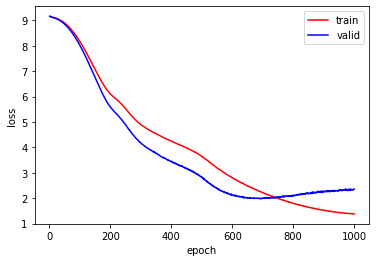

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

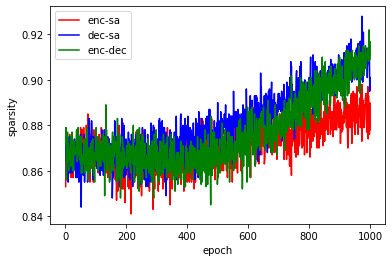

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')